<a href="https://colab.research.google.com/github/tracijo32/astralar/blob/master/full_data_2_cnn3d_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OnTarget
 
## Full 3D Convolutional Neural Network Pipeline for Walabot Data Analysis and Firearm Clip Detection

### Traci Johnson
#### Insight Data Science, in collaboration with Astral AR

In this Python notebook, we will import and reduce the data from Walabot 2D image slices to recreate 3D data cubes of radio frequency data and perform some machine learning with a neural network to classify the presence of loaded vs unloaded gun clips vs a control object.

I perform this work on Google Colaboratory in order to access its free GPU computing power. Yet, I host all relevant files on my own personal [Github](https://github.com/tracijo32/astralar). Colab has the ability to connect to Github API and commit files to your repo, as well as upload Jupyter notebooks from any github repo to save to your Google Drive. Yay! Cloud computing!

Let's get started.

In [0]:
import pandas as pd
import numpy as np

I have copied the data files to my Google Drive for easy access.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


The following script will read in the data from the raw CSV files dumped from the Walabot detector. Each image is located on a single line of the file, with a list of lists embedding the 2D matrix of the $R$ by $\phi$ image. There are a few other redundant columns, but the only most important indicates which slice of $\theta$ the image come froms. The Walabot records which ever 2D slice in $\theta$ has the highest signal at the moment of recording. Over the course of a 30 minute recording, that can vary, so we have a bunch of images of most of the slices, with the slices with highest signals having the most data. Despite the Walabot settings being identical each time the data are recorded, the slice values for $\theta$ (recorded in radians times 100) are slightly different, my guess due to the internal calibration that occurs when the Walabot is turned on. Therefore, I convert the image slice values to an integer, ranging from 0 to 11 in order of increasing $\theta$. Finally, some of the slices produce frames of all zeros, which aren't super useful, so I filter those out.

In [0]:
root_path = 'gdrive/My Drive/Walabot-Data/data-csv/'

In [0]:
def read_rawimage(file,slices=np.arange(-45,45,8),nozero=True):
    df = pd.read_csv(file,header=None)
    image_cols = df.iloc[:,:-4].astype(str)
    last_col = df.iloc[:,-2]/100*(180/np.pi)
    new_last_col = last_col.apply(lambda x: np.abs(x-slices).argmin())
    image = image_cols.apply(lambda col: np.array(eval(','.join(col.to_list()))).astype(float),axis=1)
    new_df = pd.DataFrame({'Image':image,'Slice':new_last_col})
    if nozero:
        new_df = new_df[new_df['Image'].apply(lambda x: np.max(x)) > 0]
    return new_df

Let's import the data the full magazine, empty magazine, and a glass pipe control object. The data were taken on June 19 and 20, 2019, hence the file names.

In [0]:
fullclip1 = read_rawimage(root_path+'data-RawImage-fullMag-0619.csv')
emptyclip1 = read_rawimage(root_path+'data-RawImage-empty-0619.csv')
pipe1 = read_rawimage(root_path+'data-RawImage-pipe-0619.csv')

In [0]:
fullclip2 = read_rawimage(root_path+'data-RawImage-fullMag-0620.csv')
emptyclip2 = read_rawimage(root_path+'data-RawImage-empty-0620.csv')
pipe2 = read_rawimage(root_path+'data-RawImage-pipe-0620.csv')

Let's visualize what these data sets look like by playing each slice in time sequence. This will be similar to what we see in the Rasberry Pi GUI when recording the data.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

We're going to download the celluloid package, which is a more intuitive wrapper package for matplotlib's animation package. Literally, it's just "make plot, take snap shot, now put all snaps into a video". Sadly, mpl's API really fails here with requiring you to start with a shell and write an update function using functions you would normally never use in mpl in designing your plots. Just pointing that out. Celluloid basically just allows you to FOR loop it like normals.

In [8]:
pip install celluloid

In [0]:
from celluloid import Camera

In [0]:
dfs = [fullclip1,emptyclip1,pipe1,fullclip2,emptyclip2,pipe2]
titles = ['fullclip1','emptyclip1','pipe1','fullclip2','emptyclip2','pipe2']
lenframes = [len(df) for df in dfs]

In [0]:
fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
cam = Camera(fig)
for frame in range(max(lenframes)):
    percent = frame/max(lenframes)
    for i in range(6):
        n = round(lenframes[i]*percent)
        if n == lenframes[i]:
            n = n-1
        _ = ax.flat[i].imshow(dfs[i].iloc[n,0])
    cam.snap()
_ = [ax.flat[i].set_title(titles[i]) for i in range(6)]
_ = [ax.flat[i].set_xticks([]) for i in range(6)]
_ = [ax.flat[i].set_yticks([]) for i in range(6)]
anim = cam.animate(interval=50,repeat_delay=2000);


In [12]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [0]:
anim.save(root_path + 'timesequence.mp4')

## Train/test split
We have to carefully split the data set because some of the data only have a few images per slice. We have to stratify based on slice.

In [0]:
def train_test_split_images(df,test_size=0.2,limit=5,random_state=123):
    train = []
    test = []
    for slc in df['Slice'].unique():
        subset = df[df['Slice']==slc]
        if len(subset) < limit:
            split = int(len(subset)*0.5)
        else:
            split = int(len(subset)*test_size)
        shuffle = subset.sample(frac=1,replace=False,random_state=random_state)
        train.append(shuffle.iloc[split:])
        test.append(shuffle.iloc[:split])
    return pd.concat(train),pd.concat(test)
    
    
    

In [0]:
fc1_train,fc1_test = train_test_split_images(fullclip1)
fc2_train,fc2_test = train_test_split_images(fullclip2)
ec1_train,ec1_test = train_test_split_images(emptyclip1)
ec2_train,ec2_test = train_test_split_images(emptyclip2)
pp1_train,pp1_test = train_test_split_images(pipe1)
pp2_train,pp2_test = train_test_split_images(pipe2)

In [0]:
del fullclip1,fullclip2,emptyclip1,emptyclip2,pipe1,pipe2

In order to artificially inflate the size of the data set, I perform some translations of the data cube in x and y.

In [0]:
def generate_augmented_images(df,n_images=1000,n_slices=12,
                              xshift=10,yshift=10,zshift=1,
                              xflip=False,yflip=False,zflip=False,
                              xcrop=[20,80],ycrop=[0,50],zcrop=[1,11]):
    xdim,ydim = df['Image'].iloc[0].shape
    full_stack = []
    for slc in range(n_slices):
        df_slc = df[df['Slice']==slc]
        if len(df_slc) == 0:
            sample_slc = np.zeros((n_images,xdim,ydim))
        else:
            sample_slc = np.stack(df_slc.sample(n_images,replace=True)['Image'].to_list())
        full_stack.append(sample_slc)
        
    full_stack = np.stack(full_stack,axis=3)
    
    x = np.random.randint(xshift,size=n_images)
    y = np.random.randint(yshift,size=n_images)
    z = np.random.randint(zshift,size=n_images)
    xx = np.random.randint(2)
    yy = np.random.randint(2)
    zz = np.random.randint(2)
    for i in range(n_images):
        orig = full_stack[i,:,:,:]
        aug = np.zeros_like(orig)
        aug[x[i]:,y[i]:,z[i]:] = orig[:xdim-x[i],:ydim-y[i],:n_slices-z[i]]
        if xflip and xx==1:
            aug = aug[::-1,:,:]
        if yflip and yy==1:
            aug = aug[:,::-1,:]
        if zflip and zz==1:
            aug = aug[:,:,::-1]
        full_stack[i,:,:,:] = aug
    
    full_stack = full_stack[:,xcrop[0]:xcrop[1],ycrop[0]:ycrop[1],zcrop[0]:zcrop[1]]
    
    return full_stack
        

In [0]:
fc1_train_stack = generate_augmented_images(fc1_train,n_images=len(fc1_train)*3)
del fc1_train
fc2_train_stack = generate_augmented_images(fc2_train,n_images=len(fc2_train)*3)
del fc2_train
ec1_train_stack = generate_augmented_images(ec1_train,n_images=len(ec1_train)*3)
del ec1_train
ec2_train_stack = generate_augmented_images(ec2_train,n_images=len(ec2_train)*3)
del ec2_train
pp1_train_stack = generate_augmented_images(pp1_train,n_images=len(pp1_train)*3)
del pp1_train
pp2_train_stack = generate_augmented_images(pp2_train,n_images=len(pp2_train)*3)
del pp2_train

fc1_test_stack = generate_augmented_images(fc1_test,n_images=len(fc1_test)*3)
del fc1_test
fc2_test_stack = generate_augmented_images(fc2_test,n_images=len(fc2_test)*3)
del fc2_test
ec1_test_stack = generate_augmented_images(ec1_test,n_images=len(ec1_test)*3)
del ec1_test
ec2_test_stack = generate_augmented_images(ec2_test,n_images=len(ec2_test)*3)
del ec2_test
pp1_test_stack = generate_augmented_images(pp1_test,n_images=len(pp1_test)*3)
del pp1_test
pp2_test_stack = generate_augmented_images(pp2_test,n_images=len(pp2_test)*3)
del pp2_test

In [0]:
ec1_train_stack.shape

(24, 60, 50, 10)

In [0]:
ec2_train_stack.shape

(1269, 60, 50, 10)

In [0]:
fc_train = np.vstack([fc1_train_stack,fc2_train_stack])
ec_train = np.vstack([ec1_train_stack,ec2_train_stack])
pp_train = np.vstack([pp1_train_stack,pp2_train_stack])
del fc1_train_stack,fc2_train_stack,ec1_train_stack,ec2_train_stack,pp1_train_stack,pp2_train_stack

fc_test = np.vstack([fc1_test_stack,fc2_test_stack])
ec_test = np.vstack([ec1_test_stack,ec2_test_stack])
pp_test = np.vstack([pp1_test_stack,pp2_test_stack])
del fc1_test_stack,fc2_test_stack,ec1_test_stack,ec2_test_stack,pp1_test_stack,pp2_test_stack

Now to add the labels to the data frame.

In [0]:
y_train = np.array([0]*len(fc_train) + [1]*len(ec_train) + [2]*len(pp_train))
y_test = np.array([0]*len(fc_test) + [1]*len(ec_test) + [2]*len(pp_test))

In [0]:
X_train = np.vstack([fc_train,ec_train,pp_train])
X_test = np.vstack([fc_test,ec_test,pp_test])
del fc_train,ec_train,pp_train,fc_test,ec_test,pp_test

In [0]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

## CNN architecture

I downloaded the settings for google colab from a coursera course I took. The files that are downloaded are not needed, I'm just too lazy to update the code.

In [0]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

--2019-07-01 06:29:24--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2019-07-01 06:29:25 (53.7 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]

**************************************************
102flowers.tgz
**************************************************
imagelabels.mat
**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


In [0]:
import sys
sys.path.append("..")
import download_utils

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import grading_utils
import keras_utils
from keras_utils import reset_tf_session

1.14.0
2.0.6


Convert the labels into one-hot encoded arrays.

In [0]:
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv3D, Conv2D, MaxPooling2D, MaxPooling3D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Here's where we set up the model: We've got two 3D convolutional layers and a max pool, followed by a flattening, a dense layer, and finally another dense layer of three neurons for the classification.

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv3D(16,(2,2,2),padding='same',input_shape=(60,50,10,1)))
    model.add(LeakyReLU(0.1))
    model.add(Conv3D(32,(2,2,2),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling3D((2,2,2)))
              
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    
    return model

In [0]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 60, 50, 10, 16)    144       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 50, 10, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 50, 10, 32)    4128      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 50, 10, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 25, 5, 32)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               30720256  
__________

In [0]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = reset_tf_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [0]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'walabot.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 7
# model = load_model(model_filename.format(last_finished_epoch))

In [0]:
# fit model
model.fit(
    X_train, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               keras_utils.TqdmProgressCallback(),
               keras_utils.ModelSaveCallback(model_filename)],
    validation_data=(X_test, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Learning rate: 0.005

Epoch 1/10
**************************************************
loss: 2.6185; acc: 0.8343; val_loss: 2.8930; val_acc: 0.8205
Model saved in walabot.000.hdf5
Learning rate: 0.0045

Epoch 2/10
**************************************************
loss: 1.7982; acc: 0.8881; val_loss: 2.6938; val_acc: 0.8322
Model saved in walabot.001.hdf5
Learning rate: 0.00405

Epoch 3/10
**************************************************
loss: 1.5506; acc: 0.9035; val_loss: 2.1541; val_acc: 0.8664
Model saved in walabot.002.hdf5
Learning rate: 0.003645

Epoch 4/10
**************************************************
loss: 1.4858; acc: 0.9076; val_loss: 2.1666; val_acc: 0.8656
Model saved in walabot.003.hdf5
Learning rate: 0.0032805

Epoch 5/10
**************************************************
loss: 1.4633; acc: 0.9091; val_loss: 2.1179; val_acc: 0.8679
Model saved in walabot.004.hdf5
Learning rate: 0.00295245

Epoch 6/10
**************************************************
loss: 1.4613; ac

In [0]:
y_pred_test = model.predict_proba(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

1280/1287 [============================>.] - ETA: 0s

Here's the confusion matrix for the model.

Text(0, 0.5, 'True label')

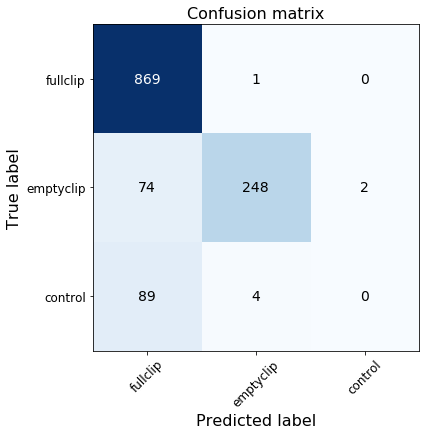

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
cm = confusion_matrix(y_test, y_pred_test_classes)
plt.xticks(np.arange(3), ['fullclip','emptyclip','control'], rotation=45, fontsize=12)
plt.yticks(np.arange(3), ['fullclip','emptyclip','control'], fontsize=12)
plt.imshow(cm,cmap='Blues')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],size=14,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted label',size=16)
plt.ylabel('True label',size=16)

In [0]:
from sklearn.metrics import f1_score

In [0]:
f1_score(y_test, y_pred_test_classes,average='weighted')

0.8341108714846476

In [0]:
accuracy_score(y_test, y_pred_test_classes)

0.8679098679098679